# <center><font color=gray>Spam Classification using Naive Bayes From scratch without Sklearn</font>
***

In [1]:
import pandas as pd

**Lecture du txt sur pandas**

In [2]:
data = pd.read_csv('C:/Users/achra/Downloads/messages.txt', sep="	", header=None)

**Renommer les colonnes**

In [3]:
data.columns = ["classe", "message"]

In [4]:
data.sample(2)

,classe,message
2342,ham,"Hmmm.... Mayb can try e shoppin area one, but ..."
4496,ham,Lol great now im getting hungry.


In [5]:
datashape = data.shape
print('Le dataset contient ' + str(datashape[0]) + ' colonnes et ' + str(datashape[1]) + ' lignes')

Le dataset contient 4998 colonnes et 2 lignes


**distribution des classes**

In [140]:
data.classe.value_counts(normalize=True) # Normalize permet de mettre en pourcentage

ham     0.865546
spam    0.134454
Name: classe, dtype: float64

**`86.5% de ham et 13.4% de spam`**

**Separation en echantillon d'apprentissage et de test**

In [7]:
# Il faut d'abord mélanger les données pour éviter les patterns
data_shuffled = data.sample(frac=1, random_state=13)

In [8]:
# Calcul de l'index sur lequel on fera le split en 80% des données
split_index = round(len(data_shuffled) * 0.8)

In [9]:
split_index

3998

In [10]:
# Train test split
training = data_shuffled[:split_index].reset_index(drop=True)
test = data_shuffled[split_index:].reset_index(drop=True)

In [11]:
training.shape

(3998, 2)

In [12]:
test.shape

(1000, 2)

**Ici on refait le calcul des pourcentages de ham et spam et training et test sets**

In [13]:
training.classe.value_counts(normalize=True)

ham     0.868684
spam    0.131316
Name: classe, dtype: float64

In [14]:
test.classe.value_counts(normalize=True)

ham     0.853
spam    0.147
Name: classe, dtype: float64

# Data preparation pour NB

In [15]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 400)

In [16]:
training.tail()

,classe,message
3993,ham,You are a great role model. You are giving so much and i really wish each day for a miracle but God as a reason for everything and i must say i wish i knew why but i dont. I've looked up to you since i was young and i still do. Have a great day.
3994,ham,Lmao!nice 1
3995,ham,How do you plan to manage that
3996,spam,No. 1 Nokia Tone 4 ur mob every week! Just txt NOK to 87021. 1st Tone FREE ! so get txtin now and tell ur friends. 150p/tone. 16 reply HL 4info
3997,ham,Still chance there. If you search hard you will get it..let have a try :)


In [17]:
training['message'] = training['message'].str.replace('\W', ' ') # \W refere a toute la ponctuation 
training['message'] = training['message'].str.lower()
training.tail()

,classe,message
3993,ham,you are a great role model you are giving so much and i really wish each day for a miracle but god as a reason for everything and i must say i wish i knew why but i dont i ve looked up to you since i was young and i still do have a great day
3994,ham,lmao nice 1
3995,ham,how do you plan to manage that
3996,spam,no 1 nokia tone 4 ur mob every week just txt nok to 87021 1st tone free so get txtin now and tell ur friends 150p tone 16 reply hl 4info
3997,ham,still chance there if you search hard you will get it let have a try


**liste avec tous les mots uniques**

In [18]:
training['message'] = training['message'].str.split() 
#Split de chaque charactere par les espaces

vocabulary = [] # initialisation de la liste vide
for message in training['message']: # On itere sur chaque message
    for word in message: # Puis sur chaque mot dans chaque message
        vocabulary.append(word) # append

vocabulary = list(set(vocabulary)) 
# Transformer en set pour enlever les duplicates puis remettre en liste

In [19]:
len(vocabulary)

7367

In [20]:
training.tail()

,classe,message
3993,ham,"[you, are, a, great, role, model, you, are, giving, so, much, and, i, really, wish, each, day, for, a, miracle, but, god, as, a, reason, for, everything, and, i, must, say, i, wish, i, knew, why, but, i, dont, i, ve, looked, up, to, you, since, i, was, young, and, i, still, do, have, a, great, day]"
3994,ham,"[lmao, nice, 1]"
3995,ham,"[how, do, you, plan, to, manage, that]"
3996,spam,"[no, 1, nokia, tone, 4, ur, mob, every, week, just, txt, nok, to, 87021, 1st, tone, free, so, get, txtin, now, and, tell, ur, friends, 150p, tone, 16, reply, hl, 4info]"
3997,ham,"[still, chance, there, if, you, search, hard, you, will, get, it, let, have, a, try]"


## Creation du dict

1. On initialise in dict avec :<br>
    Key = String de la liste (vocabulary)<br>
    Value = liste de la longueur du training set, où chaque élément de cette liste est un 0.<br>
     Le code [0] * 5 produit [0, 0, 0, 0, 0]. Ainsi, le code [0] * len(training['message']) produit une liste de la longueur du training['message'] 

In [21]:
word_count = {unique_word: [0] * len(training['message']) for unique_word in vocabulary}

# On itere sur training['message'] avec la fonction enumerate qui permet d'obtenir l'index et le msg
for index, message in enumerate(training['message']): 
    for word in message: # On itere sur les messages
        word_count[word][index] += 1 # On incremente

In [22]:
print('Nous venons de créer word_count de type : ' + str(type(word_count)))

Nous venons de créer word_count de type : <class 'dict'>


In [23]:
word_counts = pd.DataFrame(word_count) # Transformation en pd DF
word_counts.tail()

four  webpage  gamb  enna  muah  someday  piss  hidden  extract  \
3993     0        0     0     0     0        0     0       0        0   
3994     0        0     0     0     0        0     0       0        0   
3995     0        0     0     0     0        0     0       0        0   
3996     0        0     0     0     0        0     0       0        0   
3997     0        0     0     0     0        0     0       0        0   

      slippery  bt  which  terms  ovulation  panren  rajnikant  dengra  \
3993         0   0      0      0          0       0          0       0   
3994         0   0      0      0          0       0          0       0   
3995         0   0      0      0          0       0          0       0   
3996         0   0      0      0          0       0          0       0   
3997         0   0      0      0          0       0          0       0   

      graphics  864233  timin  technical  illspeak  carpark  city  assume  \
3993         0       0      0          0         0        0     0       0   
3994         0       0      0          0         0        0     0       0   
3995         0       0      0          0         0        0     0       0   
3996         0       0      0          0         0        0     0       0   
3997         0       0      0          0         0        0     0       0   

      choices  buses  user  2025050  gower  xclusive  lovable  \
3993        0      0     0        0      0         0        0   
3994        0      0     0        0      0         0        0   
3995        0      0     0        0      0         0        0   
3996        0      0     0        0      0         0        0   
3997        0      0     0        0      0         0        0   

      08452810075over18  27  parked  mathews  vote  creepy  locations  tap  \
3993                  0   0       0        0     0       0          0    0   
3994                  0   0       0        0     0       0          0    0   
3995                  0   0       0        0     0       0          0    0   
3996                  0   0       0        0     0       0          0    0   
3997                  0   0       0        0     0       0          0    0   

      buff  surfing  espe  regards  respectful  lennon  age16  sarcastic  \
3993     0        0     0        0           0       0      0          0   
3994     0        0     0        0           0       0      0          0   
3995     0        0     0        0           0       0      0          0   
3996     0        0     0        0           0       0      0          0   
3997     0        0     0        0           0       0      0          0   

      legitimat  cnn  sphosting  school  norm150p  ganesh  charlie  chinese  \
3993          0    0          0       0         0       0        0        0   
3994          0    0          0       0         0       0        0        0   
3995          0    0          0       0         0       0        0        0   
3996          0    0          0       0         0       0        0        0   
3997          0    0          0       0         0       0        0        0   

      siva  iphone  08718727870150ppm  vettam  quite  innings  bhayandar  fb  \
3993     0       0                  0       0      0        0          0   0   
3994     0       0                  0       0      0        0          0   0   
3995     0       0                  0       0      0        0          0   0   
3996     0       0                  0       0      0        0          0   0   
3997     0       0                  0       0      0        0          0   0   

      ingredients  enuff  refused  callers  greetings  unicef  post  ke  \
3993            0      0        0        0          0       0     0   0   
3994            0      0        0        0          0       0     0   0   
3995            0      0        0        0          0       0     0   0   
3996            0      0        0        0          0       0     0   0   
3997       

### Concatenation avec la variable cible

In [24]:
training_set = pd.concat([training, word_counts], axis=1)
training_set.tail(1)

classe  \
3997    ham   

                                                                                   message  \
3997  [still, chance, there, if, you, search, hard, you, will, get, it, let, have, a, try]   

      four  webpage  gamb  enna  muah  someday  piss  hidden  extract  \
3997     0        0     0     0     0        0     0       0        0   

      slippery  bt  which  terms  ovulation  panren  rajnikant  dengra  \
3997         0   0      0      0          0       0          0       0   

      graphics  864233  timin  technical  illspeak  carpark  city  assume  \
3997         0       0      0          0         0        0     0       0   

      choices  buses  user  2025050  gower  xclusive  lovable  \
3997        0      0     0        0      0         0        0   

      08452810075over18  27  parked  mathews  vote  creepy  locations  tap  \
3997                  0   0       0        0     0       0          0    0   

      buff  surfing  espe  regards  respectful  lennon  age16  sarcastic  \
3997     0        0     0        0           0       0      0          0   

      legitimat  cnn  sphosting  school  norm150p  ganesh  charlie  chinese  \
3997          0    0          0       0         0       0        0        0   

      siva  iphone  08718727870150ppm  vettam  quite  innings  bhayandar  fb  \
3997     0       0                  0       0      0        0          0   0   

      ingredients  enuff  refused  callers  greetings  unicef  post  ke  \
3997            0      0        0        0          0       0     0   0   

      disastrous  needing  messaged  inside  transfred  pls  x29  lay  \
3997           0        0         0       0          0    0    0    0   

      pobox45w2tg150p  pro  olage  soc  apps  citizen  sim  racing  amy  \
3997                0    0      0    0     0        0    0       0    0   

      3optical  trained  09058097189  hiding  yesterday  witot  advice  lotz  \
3997         0        0            0       0          0      0       0     0   

      mob  actually  sweet  440  midnight  chosen  ip  89693  soladha  \
3997    0         0      0    0         0       0   0      0        0   

      08702840625  marriage  clip  battery  texted  blessing  lock  selling  \
3997            0         0     0        0       0         0     0        0   

      sorted  group  msgrcvd18  truth  40mph  second  peak  neway  dogs  tour  \
3997       0      0          0      0      0       0     0      0     0     0   

      recycling  3030  canal  deer  tmrw  hairdressers  ü  09061221061  69101  \
3997          0     0      0     0     0             0  0            0      0   

      rcv  thnx  rumbling  helpline  errors  involved  wen  officer  clark  \
3997    0     0         0         0       0         0    0        0      0   

      airtel  murdered  throw  okors  vco  refunded  1win150ppmx3  mgs  rum  \
3997       0         0      0      0    0         0             0    0    0   

      hunt  honeymoon  cheaper  0845  wesley  1680  smoothly  eyes  wales  \
3997     0          0        0     0       0     0         0     0      0   

      reached  k52  feeling  bandages  okday  lifeis  0871750  08719181259  \
3997        0    0        0         0      0       0        0            0   

      skyped  thout  wrld  shortbreaks  packs  england  drunken  anytime  \
3997       0      0     0            0      0        0        0        0   

      outdoors  4wrd  unconditionally  newest  solved  msgs  300603  jacuzzi  \
3997         0     0                0       0       0     0       0        0   

      opinion  stopped  taka  sporadically  goto  0789xxxxxxx  freek  \
3997        0        0     0             0     0            0      0   

      person2die  crowd  4mths  usa  steps  sportsx  custom  much  god  high  \
3997           0      0      0    0      0        0       0     0    0     0   

      hold  po19  forwarded  b  voucher  wenwecan  lautech  readers  \
3997     0  

# NB

In [25]:
# Calcul des constantes

**Separer les spam et non-spam**<br>**Called Parse !!**

In [26]:
spam_messages = training_set[training_set['classe'] == 'spam']
ham_messages = training_set[training_set['classe'] == 'ham']

**P(Spam) & P(Ham)**

In [27]:
p_spam = len(spam_messages) / len(training_set)
p_ham = len(ham_messages) / len(training_set)

**N_Spam : nombre de mots contenus dans tous les messages de spam<br>
N_Ham :  nombre de mots contenus dans tous les messages de ham**

In [141]:
# N_Spam
n_spam = len(spam_messages['message'])

# N_Ham
n_ham = len(ham_messages['message'])

In [142]:
n_spam

525

In [113]:
# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

### Calcul des parametres

Maintenant le calcul des paramètres P(wi|Spam) et P(wi|Ham).

P(wi|Spam) et P(wi|Ham) varient en fonction des mots individuels. Par exemple, P("secret"|Spam) aura une certaine valeur de probabilité, tandis que P("cousin"|Spam) ou P("etudiant"|Spam) auront d'autres valeurs.

Par conséquent, chaque paramètre sera une valeur de probabilité conditionnelle associée à chaque mot du vocabulaire.

Les paramètres sont calculés à l'aide de ces deux équations :
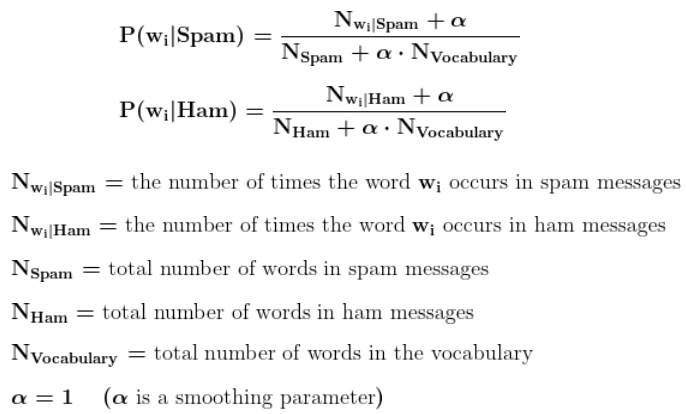

In [114]:
words_occur = pd.DataFrame()
words_occur['spam'] = training_set.loc[training_set.classe == 'spam'].iloc[:,2:].sum(axis = 0)
words_occur['ham'] = training_set.loc[training_set.classe == 'ham'].iloc[:,2:].sum(axis = 0)

In [115]:
print(words_occur)

            spam  ham
four           1    1
webpage        0    1
gamb           1    0
enna           0    1
muah           0    2
...          ...  ...
records        4    0
ahhh           0    1
specify        0    1
apparently     0    2
3qxj9          3    0

[7367 rows x 2 columns]


In [116]:
words_probs = words_occur.copy()
words_probs.spam = (words_probs.spam + alpha) / (n_spam + (alpha * n_vocabulary))
words_probs.ham = (words_probs.ham + alpha)/ (n_ham + (alpha * n_vocabulary))

In [117]:
print(words_probs)

                spam       ham
four        0.000253  0.000271
webpage     0.000127  0.000271
gamb        0.000253  0.000136
enna        0.000127  0.000271
muah        0.000127  0.000407
...              ...       ...
records     0.000634  0.000136
ahhh        0.000127  0.000271
specify     0.000127  0.000271
apparently  0.000127  0.000407
3qxj9       0.000507  0.000136

[7367 rows x 2 columns]


In [126]:
print(test.head(1))

  classe  \
0   spam   

                                                                                                                          message  \
0  For ur chance to win a £250 wkly shopping spree TXT: SHOP to 80878. T's&C's www.txt-2-shop.com custcare 08715705022, 1x150p/wk   

  estimation  
0      equal  


In [150]:
def predicteur(row):
    '''Predict if a message is either ham or spam
    Args:
        row (int): row of the message to predict
    Returns:
        str: predicted category of the message
    '''
    spam_prob = p_spam
    ham_prob = p_ham
    for item in row:
        if item in words_probs.index:
            # x *= 5 >>> x = x * 5
            spam_prob *= words_probs.loc[item, 'spam'] # multiplie la proba de chaque mot par la proba generale de spam
            ham_prob *= words_probs.loc[item,'ham']
        else:
            spam_prob *= (alpha / (alpha * n_vocabulary))
            ham_prob *= (alpha / (alpha * n_vocabulary))
    if spam_prob > ham_prob:
        return 'spam'
    elif ham_prob > spam_prob:
        return 'ham'
    else:
        return'equal'

In [151]:
test['estimation'] = test.message.apply(predicteur)

In [136]:
correct = 0
total = test.shape[0]

for row in test.iterrows():
    row = row[1]
    if row['classe'] == row['estimation']:
        correct += 1

print('Bonnes predictions :', correct)
print('Predictions eronnees :', total - correct)
print('Precision :', correct/total)

Bonnes predictions : 742
Predictions eronnees : 258
Precision : 0.742


In [137]:
y_actu = test.classe
y_actu = y_actu.replace('spam',1)
y_actu = y_actu.replace('ham',0)

y_pred = test.estimation
y_pred = y_pred.replace('spam',1)
y_pred = y_pred.replace('ham',0)


df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

In [138]:
df_confusion
# Out of 853, 742 ham observations where classified as ham and 111 as spam (false negatives)

Predicted,0,equal,All
Actual,,,
0,742,111,853
1,39,108,147
All,781,219,1000
